---
# Part 1: 环境准备与初始化
---

## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import json
from datetime import datetime

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer, PostProcessingPipeline
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter
from src.preprocessing.image_preprocessing import PREPROCESSING_METHODS

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")
print(f"✓ 可用的预处理方法: {list(PREPROCESSING_METHODS.keys())}")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 模块导入成功
✓ Matplotlib 中文支持已配置
✓ 可用的预处理方法: ['baseline', 'adaptive_threshold', 'resize_normalize', 'enhancement']


## 2. 初始化识别器

In [2]:
# 初始化自定义识别器
recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'  # 如果没有 GPU，改为 'cpu'
)

print("\n模型信息:")
model_info = recognizer.get_model_info()
for key, value in model_info.items():
    print(f"  {key}: {value}")

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec
  num_characters: 18385
  blank_index: 0
  preprocessors: ['Read', 'ReisizeNorm', 'ToBatch']


## 3. 加载测试数据

本 notebook 完全独立运行，不依赖其他 notebook 的变量。

In [3]:
from pathlib import Path
import re

# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}\n请确保文件存在")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 3. 清理 ground truth
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 清理后的 Ground Truth: {len(gt_clean)} 字符")
print(f"前 100 字符: {gt_clean[:100]}")

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 709 字符
✓ 清理后的 Ground Truth: 550 字符
前 100 字符: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會


---
# Part 2: 格子检测与分割
---

## 4. 格子检测与分割

In [4]:
# 从 src.preprocessing 导入格子检测方法
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells

# 转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域（避免边框干扰）
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)
        if h > 2*crop and w > 2*crop:
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell
        
        # 计算非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 字符数: {len(gt_clean)}")

检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 字符数: 550


## 5. 初始化后处理流程

In [5]:
# 创建后处理器（与 02.8 相同的配置）
decoder = TopKDecoder(k=5)
deduplicator = CTCDeduplicator()
conf_filter = ConfidenceFilter(threshold=0.0)

print("✓ 后处理流程初始化完成")
print(f"  - Top-K解码: k={decoder.k}")
print(f"  - CTC去重: 启用")
print(f"  - 置信度过滤: threshold={conf_filter.threshold}")

✓ 后处理流程初始化完成
  - Top-K解码: k=5
  - CTC去重: 启用
  - 置信度过滤: threshold=0.0


## 6. 定义辅助函数

In [6]:
def restore_empty_cells(results_list, cells, non_empty_cells):
    """
    恢复空格子，构建完整的预测结果
    （直接沿用 02.8 的函数）
    """
    all_cells_dict = {}
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',
            'confidence': 1.0,
            'is_empty': True
        }
    
    for i, (result, cell) in enumerate(zip(results_list, non_empty_cells)):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result
        }
    
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full


def run_ocr_with_preprocessing(cell_images, preprocess_fn=None, method_name="baseline"):
    """
    对格子图像应用预处理并执行OCR识别
    
    参数:
        cell_images: 原始格子图像列表
        preprocess_fn: 预处理函数（可选）
        method_name: 方法名称（用于日志）
        
    返回:
        results_list: OCR识别结果列表
    """
    print(f"\n执行 {method_name} 预处理 + OCR...")
    print("="*80)
    
    # 步骤1: 预处理
    if preprocess_fn is not None:
        print(f"步骤1: 应用 {method_name} 预处理...")
        preprocessed_images = [preprocess_fn(img) for img in cell_images]
        print(f"✓ 预处理完成: {len(preprocessed_images)} 个格子")
    else:
        print(f"步骤1: 跳过预处理（使用原始图像）")
        preprocessed_images = cell_images
    
    # 步骤2: 批量OCR识别
    print(f"\n步骤2: 批量OCR识别...")
    batch_raw_outputs = recognizer.batch_predict_with_raw_output(preprocessed_images)
    print(f"✓ 获取 {len(batch_raw_outputs)} 个格子的概率矩阵")
    
    # 步骤3: 后处理
    print(f"\n步骤3: 后处理（Top-K解码 → CTC去重 → 置信度过滤）...")
    results_list = []
    
    for i, raw_output in enumerate(batch_raw_outputs):
        decoded = decoder(raw_output)
        deduped = deduplicator(decoded)
        filtered = conf_filter(deduped)
        results_list.append(filtered)
        
        if i < 5:  # 显示前5个格子
            text = filtered.get('text', '')
            confidence = filtered.get('confidence', 0)
            print(f"  格子 {i+1:3d}: '{text:8s}' (置信度: {confidence:.3f})")
    
    print(f"\n✓ {method_name} 方法处理完成！")
    return results_list


print("✓ 辅助函数定义完成")

✓ 辅助函数定义完成


---
# Part 3: 四种预处理方法实验
---

## 7. 准备评估器

In [7]:
from src.evaluation import GridAccuracyCalculator

# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

print("✓ 评估器初始化完成")

✓ 评估器初始化完成


## 8. 定义预处理方法配置

In [14]:
# 预处理方法配置
preprocessing_methods = {
    'no_preprocessing': {
        'name': 'No Preprocessing',
        'function': None,
        'description': '无预处理（原始BGR图像）'
    },
    'grayscale': {
        'name': 'Grayscale',
        'function': PREPROCESSING_METHODS['baseline'],
        'description': '仅灰度化'
    },
    'adaptive_threshold': {
        'name': 'Adaptive Threshold',
        'function': PREPROCESSING_METHODS['adaptive_threshold'],
        'description': '自适应二值化 (block_size=11, C=2)'
    },
    'resize_normalize': {
        'name': 'Resize Normalize',
        'function': PREPROCESSING_METHODS['resize_normalize'],
        'description': '尺寸标准化 (target_height=48)'
    },
    'enhancement': {
        'name': 'Enhancement',
        'function': PREPROCESSING_METHODS['enhancement'],
        'description': '字符增强 (开运算+闭运算+锐化)'
    }
}

print("预处理方法配置:")
for key, config in preprocessing_methods.items():
    print(f"  {key}: {config['name']} - {config['description']}")

预处理方法配置:
  no_preprocessing: No Preprocessing - 无预处理（原始BGR图像）
  grayscale: Grayscale - 仅灰度化
  adaptive_threshold: Adaptive Threshold - 自适应二值化 (block_size=11, C=2)
  resize_normalize: Resize Normalize - 尺寸标准化 (target_height=48)
  enhancement: Enhancement - 字符增强 (开运算+闭运算+锐化)


## 9. 执行四种预处理方法实验

In [15]:
# 存储所有方法的结果
all_method_results = {}

print("开始预处理方法对比实验...")
print("="*80)

for method_key, config in preprocessing_methods.items():
    print(f"\n{'='*80}")
    print(f"方法: {config['name']}")
    print(f"描述: {config['description']}")
    print(f"{'='*80}")
    
    # 步骤1: 预处理 + OCR识别
    results_list = run_ocr_with_preprocessing(
        cell_images=cell_images,
        preprocess_fn=config['function'],
        method_name=config['name']
    )
    
    # 步骤2: 恢复空格子
    print(f"\n恢复空格子...")
    prediction_data_full = restore_empty_cells(results_list, cells, non_empty_cells)
    print(f"✓ 完整预测结果: {len(prediction_data_full)} 个格子")
    
    # 步骤3: 评估准确率
    print(f"\n评估准确率...")
    metrics = calculator.calculate(
        predicted_results=prediction_data_full,
        ground_truth=ground_truth,
        align_by_row=True
    )
    
    # 打印结果
    print(f"\n{config['name']} 准确率结果:")
    print(f"  字符准确率: {metrics['overall']['accuracy']:.2f}%")
    print(f"  正确字符数: {metrics['overall']['matched_chars']}")
    print(f"  总字符数: {metrics['overall']['total_chars']}")
    print(f"  格子匹配数: {sum(r['cell_matches'] for r in metrics['by_row'])}")
    print(f"  总格子数: {sum(r['total_cells'] for r in metrics['by_row'])}")
    
    # 保存结果
    all_method_results[method_key] = {
        'config': config,
        'results_list': results_list,
        'prediction_data_full': prediction_data_full,
        'metrics': metrics
    }

print(f"\n{'='*80}")
print("✓ 所有预处理方法实验完成！")
print(f"{'='*80}")

开始预处理方法对比实验...

方法: No Preprocessing
描述: 无预处理（原始BGR图像）

执行 No Preprocessing 预处理 + OCR...
步骤1: 跳过预处理（使用原始图像）

步骤2: 批量OCR识别...
✓ 获取 532 个格子的概率矩阵

步骤3: 后处理（Top-K解码 → CTC去重 → 置信度过滤）...
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)
✓ 获取 532 个格子的概率矩阵

步骤3: 后处理（Top-K解码 → CTC去重 → 置信度过滤）...
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)

✓ No Preprocessing 方法处理完成！

恢复空格子...
✓ 完整预测结果: 580 个格子

评估准确率...

No Preprocessing 准确率结果:
  字符准确率: 75.68%
  正确字符数: 389
  总字符数: 514
  格子匹配数: 449
  总格子数: 580

方法: Grayscale
描述: 仅灰度化

执行 Grayscale 预处理 + OCR...
步骤1: 应用 Grayscale 预处理...
✓ 预处理完成: 532 个格子

步骤2: 批量OCR识别...

✓ No Preprocessing 方法处理完成！

恢复空格子...
✓ 完整预测结果: 580 个格子

评估准确率...

No Preprocessing 准确率结果:
  字符准确率: 75.68%
  正确字符数: 389
  总字符数: 514
  格子匹配数: 449
  总格子数: 580

---
# Part 4: 结果对比与分析
---

## 10. 四种方法准确率对比

In [16]:
# 汇总对比表格
print("\n" + "="*100)
print("四种预处理方法准确率对比")
print("="*100)

print(f"{'方法':<25} {'描述':<30} {'字符准确率':<15} {'正确/总计':<15} {'格子匹配':<15}")
print("-"*100)

for method_key, result in all_method_results.items():
    config = result['config']
    metrics = result['metrics']
    
    char_acc = metrics['overall']['accuracy']
    matched = metrics['overall']['matched_chars']
    total = metrics['overall']['total_chars']
    cell_matches = sum(r['cell_matches'] for r in metrics['by_row'])
    total_cells = sum(r['total_cells'] for r in metrics['by_row'])
    
    print(f"{config['name']:<25} {config['description']:<30} {char_acc:<15.2f}% "
          f"{matched}/{total:<12} {cell_matches}/{total_cells:<12}")

print("="*100)


四种预处理方法准确率对比
方法                        描述                             字符准确率           正确/总计           格子匹配           
----------------------------------------------------------------------------------------------------
No Preprocessing          无预处理（原始BGR图像）                  75.68          % 389/514          449/580         
Grayscale                 仅灰度化                           75.68          % 389/514          449/580         
Adaptive Threshold        自适应二值化 (block_size=11, C=2)    73.54          % 378/514          435/580         
Resize Normalize          尺寸标准化 (target_height=48)       75.49          % 388/514          434/580         
Enhancement               字符增强 (开运算+闭运算+锐化)              73.15          % 376/514          436/580         
No Preprocessing          无预处理（原始BGR图像）                  75.68          % 389/514          449/580         
Grayscale                 仅灰度化                           75.68          % 389/514          449/580         
Adaptive Threshold      

## 11. 可视化对比

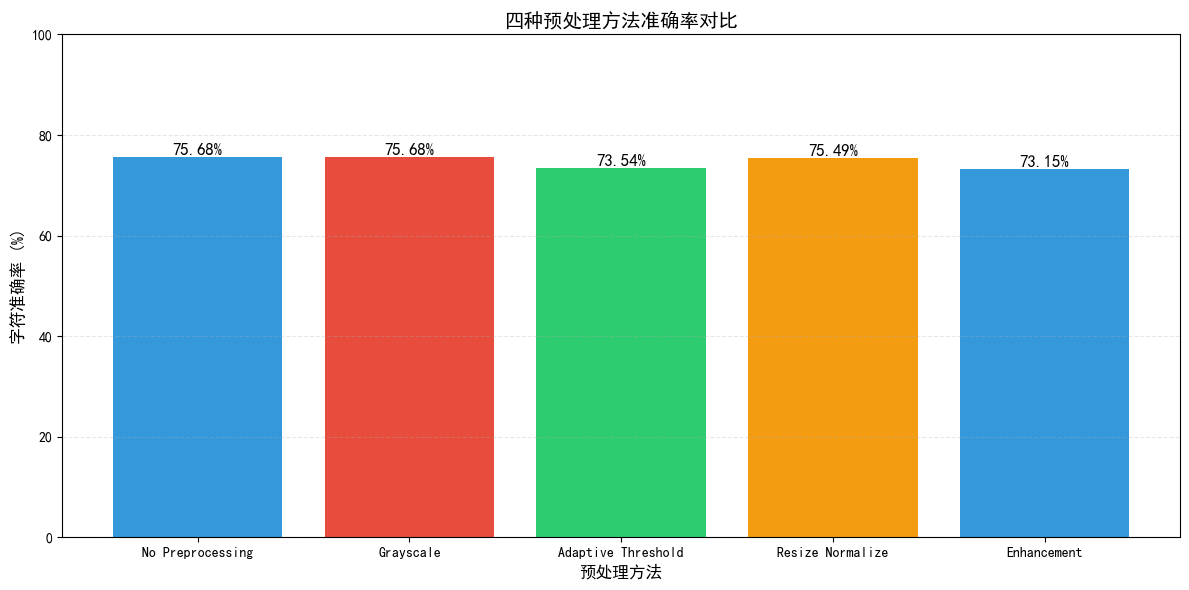

✓ 可视化完成


In [17]:
import matplotlib.pyplot as plt

# 提取数据
method_names = [result['config']['name'] for result in all_method_results.values()]
accuracies = [result['metrics']['overall']['accuracy'] for result in all_method_results.values()]

# 绘制柱状图
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(method_names, accuracies, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])

# 添加数值标签
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('预处理方法', fontsize=12)
ax.set_ylabel('字符准确率 (%)', fontsize=12)
ax.set_title('四种预处理方法准确率对比', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✓ 可视化完成")

## 12. 保存实验结果

In [18]:
# 准备保存的数据
output_data = {
    'experiment_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'image_path': str(img_path),
        'total_cells': len(cells),
        'non_empty_cells': len(non_empty_cells),
        'ground_truth_chars': len(gt_clean)
    },
    'methods': {}
}

# 提取每个方法的关键指标
for method_key, result in all_method_results.items():
    config = result['config']
    metrics = result['metrics']
    
    output_data['methods'][method_key] = {
        'name': config['name'],
        'description': config['description'],
        'character_accuracy': metrics['overall']['accuracy'],
        'matched_chars': metrics['overall']['matched_chars'],
        'total_chars': metrics['overall']['total_chars'],
        'cell_matches': sum(r['cell_matches'] for r in metrics['by_row']),
        'total_cells': sum(r['total_cells'] for r in metrics['by_row'])
    }

# 保存为 JSON
output_dir = project_root / 'output'
output_file = output_dir / 'preprocessing_methods_comparison.json'

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print(f"✓ 实验结果已保存至: {output_file}")

✓ 实验结果已保存至: C:\Users\Quenton\Documents\Github\writtingOCR\output\preprocessing_methods_comparison.json


## 13. 结论与建议

In [19]:
# 找出最佳方法
best_method_key = max(all_method_results.items(), 
                      key=lambda x: x[1]['metrics']['overall']['accuracy'])[0]
best_result = all_method_results[best_method_key]
best_config = best_result['config']
best_metrics = best_result['metrics']

print("\n" + "="*80)
print("实验结论")
print("="*80)

print(f"\n✓ 最佳预处理方法: {best_config['name']}")
print(f"  描述: {best_config['description']}")
print(f"  字符准确率: {best_metrics['overall']['accuracy']:.2f}%")

# 计算与no_preprocessing的提升
no_preprocess_acc = all_method_results['no_preprocessing']['metrics']['overall']['accuracy']
improvement = best_metrics['overall']['accuracy'] - no_preprocess_acc

print(f"\n相比No Preprocessing的提升:")
print(f"  {improvement:+.2f}% (从 {no_preprocess_acc:.2f}% → {best_metrics['overall']['accuracy']:.2f}%)")

print(f"\n{'='*80}")


实验结论

✓ 最佳预处理方法: No Preprocessing
  描述: 无预处理（原始BGR图像）
  字符准确率: 75.68%

相比No Preprocessing的提升:
  +0.00% (从 75.68% → 75.68%)

